<a href="https://colab.research.google.com/github/anaconda121/CTC/blob/main/CTC_Systematic_Equities_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as plt
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.forecasting.theta import ThetaModel

# temporary import
from sktime.utils.plotting import plot_series

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Systematic Equities Case Study

In [2]:
emerging_market_countries = ['BRA','MEX','IND','CHN','ZAF']
developed_market_countries = ['USA','JPN','DEU','GBR','FRA']

columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # total data
features = ['Open', 'Close', 'High', 'Low', 'Volume'] # input features

# end_date = "2023-10-04" # end date that our model is allowed to use as training data, should be edited when case is being graded

In [7]:
# example of portfolio:
# keys: countries, values: array of five stock tickers.

portfolio = {
            'BRA': ['PBR','VALE','ITUB','NU','BSBR'],
            'MEX': ['AMX','KCDMY','VLRS','ALFAA.MX','BBAJIOO.MX'],
            'IND': ['RELIANCE.NS','TCS', 'HDB', 'INFY', 'ADANIENT.NS'],
            'USA': ['AAPL', 'MSFT','GOOG','AMZN','NVDA']
            }

stock_mapping = {}
for country in portfolio:
    for stock in portfolio[country]:
        stock_mapping[stock] = country

In [10]:
def get_data(portfolio, start_date, end_date):
    # Initialize an empty DataFrame
    data = pd.DataFrame()

    # Create an empty list for columns
    columns = []

    # Loop through each country in the portfolio
    for country, tickers in portfolio.items():
        # Download data for each ticker
        df = yf.download(tickers, start=start_date, end=end_date)

        # Extract the columns representing stock attributes (e.g., 'Adj Close', 'Volume', etc.)
        stock_attributes = df.columns.levels[0]

        # Extend the list of columns with country and attribute prefix
        country_columns = [(country, attr, ticker) for ticker in tickers for attr in stock_attributes]
        columns.extend(country_columns)

        # Concatenate the data to the main DataFrame
        data = pd.concat([data, df], axis=1)

    # Create a multi-index header
    data.columns = pd.MultiIndex.from_tuples(columns)
    return data

In [24]:
data = get_data(portfolio, start_date='2015-01-01', end_date='2023-01-01')
data.interpolate(method = 'linear', inplace = True,limit_direction = 'both')

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


In [14]:
def generate_individal_equity_data(portfolio, data):
    equity_dfs = {}
    ticker_list = []

    for country in portfolio:
        for stock in portfolio[country]:
            df = pd.DataFrame(data.index) # initializing default df to have dates from 01-01-2023 -> 10-04-2023
            ticker_list.append(stock)
            for col in columns:
                col_data = data[country][col][stock].reset_index() # assigning equity data to df
                df[col] = col_data[stock]
            equity_dfs[stock] = df

    return equity_dfs


def generate_predicted_returns(df):
    # computing daily return
    daily_return_vals = []
    for i, row in df.iterrows():
        if (i == 0):
            daily_return_vals.append(0)
        else:
            ret = (df.loc[[i]]["EWMA-30"][i]) / (df.loc[[i-1]]["EWMA-30"][i-1]) - 1.00
            daily_return_vals.append(ret)

    # getting next day return to use as output feature
    next_day_return = []
    for i, row in df.iterrows():
        if (i == len(df) - 1):
            next_day_return.append(0)
        else:
            next_day_return.append(daily_return_vals[i + 1])

    return next_day_return

In [32]:
pd.DataFrame(columns = ["AAPL"])

,AAPL


In [33]:
def strategy(portfolio, start_date, end_date):
    data = get_data(portfolio, start_date=start_date, end_date=end_date)
    data.interpolate(method = 'linear', inplace = True, limit_direction = 'both')
    equity_dfs = generate_individal_equity_data(portfolio, data)
    trading_list = pd.DataFrame(columns = data.columns.levels[2])

    for ticker in data.columns.levels[2]:
        curr_data = equity_dfs[ticker]
        curr_data["EWMA-30"] = curr_data["Adj Close"].ewm(span = 30).mean()
        curr_data["Next Day Returns"] = generate_predicted_returns(curr_data)
        ticker_trades = pd.DataFrame(columns = [ticker])

        row_counter = 0
        for dates in curr_data["Date"]:
            if (row_counter > 0):
                if curr_data.loc[[row_counter]]["Next Day Returns"][row_counter] > 0:
                    ticker_trades.loc[dates] = 1
                else:
                    ticker_trades.loc[dates] = -1
            else:
                ticker_trades.loc[dates] = np.nan
            row_counter += 1

        trading_list[ticker] = ticker_trades

    trading_list_one = trading_list.sub(trading_list.mean(axis=1), axis=0)
    trading_list_normalized = trading_list_one.div(trading_list_one.abs().sum(axis=1), axis=0)
    return trading_list_normalized

In [34]:
trading_list = strategy(portfolio, start_date='2015-01-01',end_date='2023-01-01')
trading_list.head(5)

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,AAPL,ADANIENT.NS,ALFAA.MX,AMX,AMZN,BBAJIOO.MX,BSBR,GOOG,HDB,INFY,ITUB,KCDMY,MSFT,NU,NVDA,PBR,RELIANCE.NS,TCS,VALE,VLRS
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,0.500000,-0.026316,-0.026316,-0.026316
2015-01-05,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,0.166667,-0.029412
2015-01-06,0.055556,-0.045455,0.055556,0.055556,-0.045455,-0.045455,0.055556,-0.045455,0.055556,-0.045455,-0.045455,0.055556,-0.045455,-0.045455,-0.045455,0.055556,-0.045455,0.055556,0.055556,-0.045455
2015-01-07,0.038462,0.038462,0.038462,0.038462,0.038462,-0.071429,0.038462,-0.071429,0.038462,-0.071429,-0.071429,0.038462,-0.071429,0.038462,-0.071429,0.038462,0.038462,0.038462,0.038462,-0.071429


In [ ]:
'''
Overview: the following function is a very simple (albeit stupid) trading strategy where
if the log returns are negative we short the stock and if the log returns are positive
we long the returns. We do an equal weightage across all the stocks for simplicity.

Input:
portfolio: a dictionary of the same format provided above.
start_date: 'year-month-day'
end_date : 'year-month-day'

Return: a data frame where the indeces are dates (only trading days) between
the start-date and end-date provided above. For a given date (i.e a row) the following
two conditions must hold:

1. The absolute value of the holdings sum to 1.
2. The value of the holdings sum to 0 (i.e long/short across the entire portfolio).
'''
def simple_strat(portfolio, start_date, end_date):
    data = get_data(portfolio,start_date = start_date, end_date = end_date)
    trading_list = pd.DataFrame(columns = data.columns.levels[2])
    for country in data.columns.levels[0]:
        for ticker in data[country]['Adj Close'].columns:
            returns = (data[country]['Adj Close'][ticker])
            log_returns = (returns / returns.shift(1)).apply(lambda x: np.log(x))
            ticker_trades = pd.DataFrame(columns = [ticker])
            for date in log_returns.index:
                if (log_returns[date] > 0):
                    ticker_trades.loc[date] = 1
                else:
                    ticker_trades.loc[date] = -1
            trading_list[ticker] = ticker_trades
    trading_list_one = trading_list.sub(trading_list.mean(axis=1), axis=0)
    trading_list_normalized = trading_list_one.div(trading_list_one.abs().sum(axis=1), axis=0)
    return trading_list_normalized


In [ ]:
# this is what the output to our trading strategy looks like
trading_list = simple_strat(portfolio, start_date='2015-01-01',end_date='2023-01-01')
trading_list.head(5)

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,AAPL,ADANIENT.NS,ALFAA.MX,AMX,AMZN,BBAJIOO.MX,BSBR,GOOG,HDB,INFY,ITUB,KCDMY,MSFT,NU,NVDA,PBR,RELIANCE.NS,TCS,VALE,VLRS
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778
2015-01-05,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,0.500000,-0.026316,-0.026316,-0.026316
2015-01-06,0.083333,-0.035714,0.083333,0.083333,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,0.083333,-0.035714
2015-01-07,0.035714,0.035714,0.035714,0.035714,-0.083333,0.035714,0.035714,-0.083333,0.035714,0.035714,-0.083333,0.035714,0.035714,0.035714,-0.083333,0.035714,-0.083333,0.035714,0.035714,-0.083333


In [35]:
'''
Given a trading list check to see if the portfolio weights sum to 0 and if the
 absolute value of the weights sum to 1.
'''

def check_long_short(trading_list):
    vals = trading_list.sum(axis = 1)
    abs_vals = trading_list.abs().sum(axis = 1)
    def is_close_to_zero(value, threshold=1e-6):
        return abs(value) <= threshold

    def is_close_to_one(value, threshold=(1+1e-6)):
        return abs(value) <= threshold

    # Apply the function to all elements in the Series
    result = vals.apply(lambda x: is_close_to_zero(x))
    result_ones = abs_vals.apply(lambda x: is_close_to_one(x))
    # Check if all values are close to 0
    all_close_to_zero = result.all()
    # Check if all values are close to 1
    all_close_to_one= result_ones.all()
    return all_close_to_zero, all_close_to_one

In [36]:
check_long_short(trading_list)

(True, True)

In [37]:
'''
check to see if the daily turn over is less than the treshold (0.25)
'''
def check_turn_over(trading_list, treshold):
    abs_turn_over = trading_list.diff().abs().sum(axis = 1)

    def is_close_to_turnover(value, threshold=(treshold+1e-6)):
        return abs(value) <= threshold

    # Apply the function to all elements in the Series
    result_turnover = abs_turn_over.apply(lambda x: is_close_to_turnover(x))
    # Check if all values are close to 0
    all_close_to_turnover = result_turnover.all()
    return all_close_to_turnover

In [38]:
check_turn_over(trading_list, 0.25)

False

In [39]:
trading_list

,AAPL,ADANIENT.NS,ALFAA.MX,AMX,AMZN,BBAJIOO.MX,BSBR,GOOG,HDB,INFY,ITUB,KCDMY,MSFT,NU,NVDA,PBR,RELIANCE.NS,TCS,VALE,VLRS
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,0.500000,-0.026316,-0.026316,-0.026316
2015-01-05,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,0.166667,-0.029412
2015-01-06,0.055556,-0.045455,0.055556,0.055556,-0.045455,-0.045455,0.055556,-0.045455,0.055556,-0.045455,-0.045455,0.055556,-0.045455,-0.045455,-0.045455,0.055556,-0.045455,0.055556,0.055556,-0.045455
2015-01-07,0.038462,0.038462,0.038462,0.038462,0.038462,-0.071429,0.038462,-0.071429,0.038462,-0.071429,-0.071429,0.038462,-0.071429,0.038462,-0.071429,0.038462,0.038462,0.038462,0.038462,-0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000
2022-12-27,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000
2022-12-28,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,0.100000,-0.033333,0.100000
2022-12-29,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,-0.035714,-0.035714,0.083333,-0.035714,0.083333,-0.035714,0.083333


trading_list

1000

APPL: 0.5 (50)   --> $500   AMZN: -0.5 (50) --> $-500
APPL: 0.3  (60) -->     AMZN: 0.7 (30) -->

200/60 -> 3.333, -> 33.333
1000
APPL:
0.2               1.2



P = 1000
[APPL, AMZN, GOOG, TSLA]
DAY 1: [0.25,0.25,-0.25,-0.25]
APPL: 50, AMZN: 20, GOOG: 30, TSLA: 40
5, 12.5, 8.33, 6.25

DAY 2: [0.3,0.2,-0.4,-0.1]
APPL: 60, : 10, GOOG: 50, TSLA: 40
APPL: 5+50/60(300), 12.5





In [40]:
'''
Overview: given a trading list of portfolio holdings use yfinance to find the
overall pnl.

# check PNL is not negative

# if you loose all your money your done
# make sure all dates are within bounds
# make sure dates are every day
# make sure dates are order
# make sure weights sum to 0 and absolute value to 1
#
#weights after closing day
'''

def backtest(trading_list: pd.DataFrame,x_list, y_list) -> None:
   check_date(trading_list)
   check_weights(trading_list)
   check_pnl(trading_list,x_list, y_list)


   # new_list = trading_list.copy(deep=True)
   # new_row = {'AAPL': 1, 'GOOG': np.nan}
   # new_list.loc["1"] = new_row
   # check_date(new_list)
   # new_list.loc[pd.to_datetime("2023-01-01")] = new_row
   # check_weights(new_list)
   # check_date(new_list)
# "will be sent in two days"

def check_weights(trading_list: pd.DataFrame) -> None:
   assert (trading_list.isna().all(axis=1) | trading_list.notna().all(axis=1)).all(), "There is a row with some, but not all NaN values"

   row_sums = abs(trading_list.sum(axis=1)) < 1e-5
   assert row_sums.all(), "Weights do not add up to zero"

   row_sums_abs = abs(trading_list.abs().sum(axis=1)) - 1 < 1e-5
   assert row_sums_abs.all(), "Absolute values of weights do not add up to one"

def calculate_money(index, holdings, values):
   if holdings == {}:
      return sum(values.values())
   value = 0
   for stock in holdings:
      num_stock = holdings[stock]
      country = stock_mapping[stock]
      stock_value_eod = data[country]['Adj Close'].loc[index][stock]
      if math.isnan(stock_value_eod):
         value += values[stock]
      else:
         value += num_stock*stock_value_eod
   return value

# Make Sure PNL is not negative and if at any moment your money is 0, you are done.
def check_pnl(trading_list: pd.DataFrame,x_list, y_list) -> None:
   stock_holdings = defaultdict(float)
   stock_holdings_values = defaultdict(float)
   for stock in stock_mapping:
      stock_holdings_values[stock] = 100000/len(stock_mapping)

   for cur_day, row in trading_list.iterrows():
      if row.isna().all():
         continue

      cur_money = calculate_money(cur_day, stock_holdings,stock_holdings_values) # sold everything
      build = 0
      for stock, weight in row.items():
         num_stocks_value = cur_money * weight
         country = stock_mapping[stock]
         stock_value_eod = data[country]['Adj Close'].loc[cur_day][stock]
         if weight < 0:
            stock_holdings[stock] = num_stocks_value / stock_value_eod if not math.isnan(stock_value_eod) else stock_holdings[stock]
            stock_holdings_values[stock] = num_stocks_value
         else:
            stock_holdings[stock] = 3*num_stocks_value / stock_value_eod if not math.isnan(stock_value_eod) else stock_holdings[stock]
            stock_holdings_values[stock] = 3*num_stocks_value

         build += stock_holdings_values[stock]
      x_list.append(cur_day)
      y_list.append(build)
      assert build > 0 , "you lost all your money"

def check_date(trading_list: pd.DataFrame) -> None:
   assert all(isinstance(idx, pd.Timestamp) for idx in trading_list.index), "An index is not a datetime object"

   start_date = pd.to_datetime('2015-01-01')
   end_date = pd.to_datetime('2023-01-01')
   all_within_timeframe = (trading_list.index >= start_date) & (trading_list.index <= end_date)
   assert all(all_within_timeframe), "You have elements outside of the date range"

   assert len(set(trading_list.index)) == len(trading_list.index), "Cannot have rows with duplicate dates"

   assert len(data.index) == len(trading_list.index), "Need to cover all days"

   assert list(trading_list.index) == list(data.index), "Rows must be in order"


In [41]:
time_stamps = []
pnl_on_day = []
backtest(trading_list,time_stamps,pnl_on_day)

Text(0, 0.5, 'PNL')

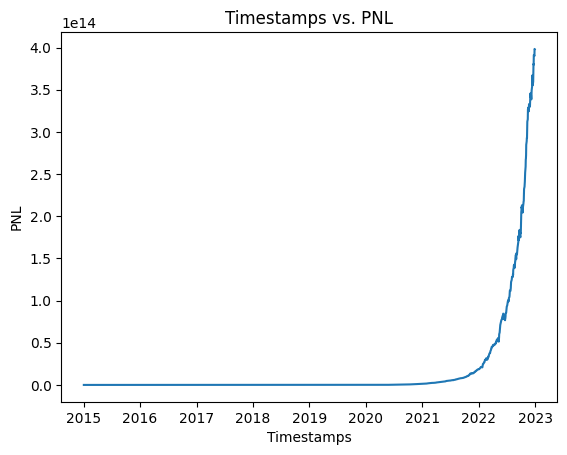

In [42]:
plt.plot(time_stamps,pnl_on_day)
plt.title('Timestamps vs. PNL')
plt.xlabel('Timestamps')
plt.ylabel('PNL')

In [43]:
pnl_on_day

[100000.0,
 103605.96877905248,
 107880.77437576647,
 112535.26448545483,
 117002.79947742322,
 118111.51668471232,
 117305.64877546496,
 121043.13556230367,
 122183.9590768273,
 126975.88451836065,
 129620.89786426947,
 129900.91947614237,
 131075.88485908136,
 133297.4976107217,
 138048.65581268817,
 139743.11022678926,
 140094.78689971284,
 141176.4244612611,
 142706.73521132683,
 146366.60508227095,
 156636.68767372094,
 158906.5158872677,
 162612.80505709111,
 166093.18452873066,
 165994.39585076715,
 168889.38307100962,
 168168.76559399525,
 173046.56355836501,
 178984.79962904382,
 181566.13123137093,
 185105.34641946232,
 185200.8336202545,
 186298.6887013286,
 185835.5779117246,
 188929.5722079399,
 189853.89759217543,
 190164.33932020588,
 195028.74759190652,
 196230.50275100142,
 199696.96740600714,
 201872.46984321595,
 202126.72236041908,
 205110.80777260914,
 205181.45444321574,
 207357.3857101438,
 207570.33456281474,
 205665.5466565786,
 205085.39528586683,
 204805.2675